## Assignment 3: Gnerating Sneaker Designs

In [2]:
# DO NOT REMOVE!
import os

import pickle

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np

from datasets import load_dataset

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split


from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

from pytorch_model_summary import summary

### Data

In [3]:
# Verify that the Kaggle JSON file is correctly placed
import os

kaggle_json_path = os.path.join(os.path.expanduser('~'), '.kaggle', 'kaggle.json')
if not os.path.exists(kaggle_json_path):
    raise FileNotFoundError(f"{kaggle_json_path} not found. Please ensure the file is placed correctly.")


In [5]:
!pip install kaggle

In [6]:
!kaggle datasets download -d aahashemi/sneaker-image-dataset

Dataset URL: https://www.kaggle.com/datasets/aahashemi/sneaker-image-dataset
License(s): unknown




  0%|          | 0.00/1.09G [00:00<?, ?B/s]
  0%|          | 1.00M/1.09G [00:00<10:45, 1.81MB/s]
  0%|          | 2.00M/1.09G [00:00<07:13, 2.69MB/s]
  0%|          | 3.00M/1.09G [00:01<06:02, 3.22MB/s]
  0%|          | 4.00M/1.09G [00:01<05:55, 3.28MB/s]
  0%|          | 5.00M/1.09G [00:01<05:41, 3.41MB/s]
  1%|          | 6.00M/1.09G [00:01<05:20, 3.62MB/s]
  1%|          | 7.00M/1.09G [00:02<05:36, 3.46MB/s]
  1%|          | 8.00M/1.09G [00:02<05:34, 3.47MB/s]
  1%|          | 9.00M/1.09G [00:02<05:07, 3.77MB/s]
  1%|          | 10.0M/1.09G [00:03<04:58, 3.88MB/s]
  1%|          | 11.0M/1.09G [00:03<05:08, 3.75MB/s]
  1%|1         | 12.0M/1.09G [00:03<05:12, 3.70MB/s]
  1%|1         | 13.0M/1.09G [00:03<05:00, 3.84MB/s]
  1%|1         | 14.0M/1.09G [00:04<04:53, 3.93MB/s]
  1%|1         | 15.0M/1.09G [00:04<04:45, 4.03MB/s]
  1%|1         | 16.0M/1.09G [00:04<04:47, 4.01MB/s]
  2%|1         | 17.0M/1.09G [00:04<04:34, 4.20MB/s]
  2%|1         | 18.0M/1.09G [00:05<04:12, 4.55MB/s]
 

In [3]:
import zipfile
import os

# Define the path to your ZIP file and the directory to extract to
zip_file = 'sneaker-image-dataset.zip'
extract_dir = './data/'

# Check if the ZIP file exists
if not os.path.exists(zip_file):
    raise FileNotFoundError(f"{zip_file} not found. Please ensure the file is in the correct location.")

# Create the extraction directory if it does not exist
os.makedirs(extract_dir, exist_ok=True)

# Open and extract the ZIP file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")


KeyboardInterrupt: 

In [178]:
class Sneakers(Dataset):
    """Sneaker Image dataset."""

    def __init__(self, image_files, transforms=None):
        self.image_files = image_files
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB if needed

        if self.transforms:
            image = self.transforms(image)

        return image



In [179]:
# Define the dimensions
L = 100  # Size of the latent vector
M = 256  # Hidden layer size
D = 128 * 128 * 3  # Flattened image size
print(D)
lr_gen = 3e-3 # learning rate
lr_dis = 3e-3 # learning rate
num_epochs = 50 # max. number of epochs

49152


### GAN

#### Generator

In [180]:
class Generator(nn.Module):
    def __init__(self, z_size):
        super(Generator, self).__init__()
        self.z_size = z_size
        self.generator_net = nn.Sequential(
            nn.Linear(z_size, 8 * 8 * 256),  # Output: (batch_size, 8*8*256)
            nn.ReLU(True),
            nn.Unflatten(1, (256, 8, 8)),    # Output: (batch_size, 256, 8, 8)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 128, 16, 16)
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # Output: (batch_size, 64, 32, 32)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # Output: (batch_size, 3, 64, 64)
            nn.ReLU(True),
            nn.ConvTranspose2d(3, 3, kernel_size=4, stride=2, padding=1),       # Output: (batch_size, 3, 128, 128)
            nn.Tanh()  # Output: (batch_size, 3, 128, 128)
        )

    def forward(self, x):
        return self.generator_net(x)

    def sample(self, batch_size):
        z = torch.randn(batch_size, self.z_size).to(next(self.parameters()).device)
        return self.forward(z)


#### Discriminator

In [181]:


import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # Input: (batch_size, 3, 128, 128)
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 128, 64, 64)
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 256, 32, 32)
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 512, 16, 16)
            nn.ReLU(True),
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 1, 8, 8)
            nn.Sigmoid()  # Output: (batch_size, 1, 8, 8)
        )

    def forward(self, x):
        x = self.discriminator_net(x)
        return x.view(x.size(0), -1)

# Example usage:
generator = Generator(z_size=100)
discriminator = Discriminator()
sample_input = torch.randn(64, 100)  # Example batch of noise vectors
generated_images = generator(sample_input)
output = discriminator(generated_images)
print(generated_images.shape)  # Check generator output shape
print(output.shape)  # Check discriminator output shape

torch.Size([64, 3, 128, 128])
torch.Size([64, 16])


#### GAN

In [182]:
class GAN(nn.Module):
    def __init__(self, generator, discriminator, epsilon=1e-7):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.epsilon = epsilon

    def forward(self, x_real, reduction='mean', mode='discriminator'):
        if mode == 'generator':
            x_fake_gen = self.generator.sample(x_real.shape[0])
            d_fake = torch.clamp(self.discriminator(x_fake_gen), self.epsilon, 1. - self.epsilon)
            loss = torch.log(1. - d_fake)

        elif mode == 'discriminator':
            x_fake_gen = self.generator.sample(x_real.shape[0])
            d_fake = torch.clamp(self.discriminator(x_fake_gen), self.epsilon, 1. - self.epsilon)
            d_real = torch.clamp(self.discriminator(x_real), self.epsilon, 1. - self.epsilon)
            loss = -(torch.log(d_real) + torch.log(1. - d_fake))
        
        if reduction == 'sum':
            return loss.sum()
        else:
            return loss.mean()
            
    def sample(self, batch_size=64):
        return self.generator.sample(batch_size=batch_size)


#### Evaluation

In [183]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss_gen = 0.
    loss_dis = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t_gen = model_best.forward(test_batch, reduction='sum', mode='generator')
        loss_t_dis = model_best.forward(test_batch, reduction='sum', mode='discriminator')
        
        loss_gen = loss_gen + loss_t_gen.item()
        loss_dis = loss_dis + loss_t_dis.item()
        
        N = N + test_batch.shape[0]
    
    loss_gen = loss_gen / N
    loss_dis = loss_dis / N

    if epoch is None:
        print(f'FINAL LOSS: gen={loss_gen}, dis={loss_dis}')
    else:
        print(f'Epoch: {epoch}, val gen={loss_gen}, val dis={loss_dis}')

    return loss_gen, loss_dis


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val, xaxis='epochs', yaxis='nll'):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

Training

In [184]:
def training(name, num_epochs, model, optimizer_gen, optimizer_dis, training_loader, val_loader):
    gen_val = []
    dis_val = []
    best_loss = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            
            # -Discriminator
            loss_dis = model.forward(batch, mode='discriminator')
                        
            optimizer_dis.zero_grad()
            optimizer_gen.zero_grad()
            loss_dis.backward(retain_graph=True)
            optimizer_dis.step()
            
            # -Generator
            loss_gen = model.forward(batch, mode='generator')
            
            optimizer_dis.zero_grad()
            optimizer_gen.zero_grad()
            loss_gen.backward(retain_graph=True)
            optimizer_gen.step()

        # Validation
        loss_val_gen, loss_val_dis = evaluation(val_loader, model_best=model, epoch=e)
        gen_val.append(loss_val_gen)  # save for plotting
        dis_val.append(loss_val_dis)  # save for plotting
        
        torch.save(model, name + '.model')
        samples_generated(name, val_loader, extra_name="_epoch_" + str(e))

    gen_val = np.asarray(gen_val)
    dis_val = np.asarray(dis_val)

    return gen_val, dis_val

In [185]:

transforms_train = tt.Compose([
    tt.Resize((128, 128)),
    tt.ToTensor(),  # Convert to tensor
    tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

transforms_val = tt.Compose([
    tt.Resize((128, 128)),
    tt.ToTensor(),  # Convert to tensor
    tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [186]:
data_dir = '.\\data\\sneaker-image-dataset'

# List all image files
image_files = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.jpg') or fname.endswith('.png')]

# Split the data into training, validation, and test sets
train_files, temp_files = train_test_split(image_files, test_size=0.4, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.2, random_state=42)

# Create dataset objects
train_data = Sneakers(train_files, transforms=transforms_train)
val_data = Sneakers(val_files, transforms=transforms_val)
test_data = Sneakers(test_files, transforms=transforms_val)


In [187]:
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [188]:
len(train_data), len(val_data), len(test_data)

(14367, 7663, 1916)

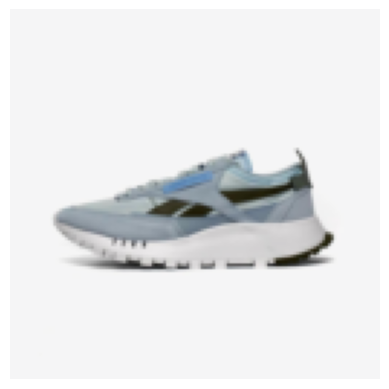

In [189]:
# Display an image from the dataset
def show_image(image):
    # Convert the image tensor to a NumPy array and transpose to (H, W, C) format
    image = image.numpy().transpose((1, 2, 0))
    # Unnormalize the image
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Get an image from the train loader
for images in training_loader:
    # Take the first image in the batch
    img = images[0]
    show_image(img)
    break

In [190]:
print(train_data[1].shape)

torch.Size([3, 128, 128])


In [191]:
if not(os.path.exists('results')):
    os.mkdir('results')
name = 'gan_' + str(L)
result_dir ='results/' + name + '/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

In [193]:
# First, we initialize the generator and the discriminator


generator = Generator(z_size=L)



discriminator = Discriminator()

# Eventually, we initialize the full model
model = GAN(generator=generator, discriminator=discriminator)

In [194]:
# OPTIMIZER
optimizer_gen = torch.optim.Adam(model.generator.parameters(), lr=lr_gen)
optimizer_dis = torch.optim.Adam(model.discriminator.parameters(), lr=lr_dis)

In [ ]:
# Training procedure
gen_val, dis_val = training(name=result_dir + name, 
                            num_epochs=num_epochs, 
                            model=model, 
                            optimizer_gen=optimizer_gen,
                            optimizer_dis=optimizer_dis,
                            training_loader=training_loader, 
                            val_loader=val_loader)